# COMP-767: Reinforcement Learning - Assignment 2

## Students
#### Rahul Patel      260904634
#### Xiangyi Zhang     260906083

# Question 2 a)
Implement and compare empirically Monte Carlo and TD-learning with eligibility traces and
linear function approximation on the Pendulum-v0 domain from the Gym environment suite:
https://gym.openai.com/envs/Pendulum-v0/
You should evaluate the fixed policy that produces torque in the same direction as the current
velocity with probability 0.9 and in the opposite direction with probability 0.1. If velocity is
0, you can torque in a random direction. For this experiment, you should use a tile coding
function approximator, in which you discretize the angular position and angular velocity
into 10 bins each, and use 5 overlapping tilings, whose weights start initialized randomly
between -0.001 and 0.001. You will need to use the same seed for this initialization for all
parameters settings, but will have 10 different seeds (for the different runs). You should use
values of $\lambda = [0, 0.3, 0.7, 0.9; 1.0]$. For each value, use 3 settings of the learning rate parameter
$\alpha=1/4; 1/8; 1/16$. Remember that the learning rate per parameter needs to be divided by
the number of overlapping tilings. Perform 10 independent runs, each of 200 episodes. Each
episode should start art state (0,0). Plot 5 graphs, one for each of the $\lambda$ values, showing the
value of the start state, using each of the $\alpha$ values (each of the 5 graphs has 3 curves). Explain
briefly what you can conclude from these graphs, in terms of the speed of convergence and
stability of these algorithms.

## Codes

### Import packages:

In [1]:
import matplotlib
import numpy as np
import random as rd
import gym
import matplotlib.pyplot as plt
import math

### Tile coding part: 

In [10]:
# The codes are mainly based on
# https://github.com/udacity/deep-reinforcement-learning/tree/master/tile-coding
"""
MIT License

Copyright (c) 2018 Udacity

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

"""
"""
The arguments:
low: the lower bound of the state space;
high: the upper bound of the state space;
bins: a multi-dimensional array. Its length is how many parameters used to describe a state (e.g. the dimension of "low" or "high")
while, for each axis (apart from 0th), a dimension goes for how many blocks you want to split the continuous space;
offsets: a multi-dim array. Its length respects to the length of bins and basically it's the offset for each dimension
"""

def grids(low, high, bins, offsets):
    assert(len(bins) == len(low) and len(high)==len(low) and len(bins) == len(offsets))
    grid = [np.linspace(low[dim], high[dim], bins[dim]+1 )[1:-1]+ offsets[dim] for dim in range(len(bins))]
    return grid

def Tilings(low, high, tiling_specs):
    return [grids(low, high, bins, offsets) for bins, offsets in tiling_specs]


def discretize(sample, grid):
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension

def encode_tile(sample, tilings, flatten=False):
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

### A class for function approximation
The class basically is a function approximator which has a weight vector and a feature vector. The class provides estimated value given a state and also function to get gradient.

In [11]:

#abstract class of function approximator
class function_approximator:

    def __init__(self,tilings):
        self.tilings = tilings

    def estimated_value(self,state):
        pass

    def get_gradient(self,status):
        pass


class linear_function_approximator(function_approximator):

    def __init__(self,tilings,lb,ub,seed):
        function_approximator.__init__(self,tilings)
        self.lb = lb
        self.ub = ub
        self.seed = seed
        self.weights = self._initialize_weights()


    def _initialize_weights(self):
        np.random.seed(self.seed)
        state_sizes = [tuple(len(split)+1 for split in self.tilings[0])]
        return np.random.uniform(self.lb,self.ub,(len(self.tilings),)+state_sizes[0])

    def _get_features(self,state):
        encoded_state = encode_tile(state, self.tilings, flatten=False)
        features = np.zeros_like(self.weights)
        for idx_tile, state_idx in enumerate(encoded_state):
            features[idx_tile][state_idx] = 1
        assert(np.sum(features) == len(self.tilings) )
        return features

    def estimated_value(self,state):
        features = self._get_features(state)
        return np.sum(np.multiply(features, self.weights))

    def get_gradient(self,state):
        return self._get_features(state)

    def update_weights(self,delta_weights):
        self.weights += delta_weights

    def reset_weights(self):
        self.weights*=0



### This class is the center of our codes. The TD eligibility trace algorithm is implemented in this part.

In [12]:
class Agent:

    """
    the input state here is not discretilized
    v is the velocity of the current pendulum
    """
    def __init__(self,env, lamb, gamma, alpha, function_approximator,episode_n):
        self.env =env
        self.lamb = lamb
        self.gamma = gamma
        self.alpha = alpha
        self.state = np.zeros(2)
        self.approximator = function_approximator
        self.episode_n = episode_n
    """"
    Here we use the angular position and angular velocity as our states, so we need to 
    transfer the cos, sin to angular position
    """

    def _reset_state(self):
        self.state = np.zeros(2)
        self.env.state =np.zeros(2)
    """"
    Generate the policy to be evaluated
    torque in the same direction as the current velocity with probability 0.9
    torque the opposite direction as the current velocity with probability 0.1
    torque whichever direction if the current velocity is 0
    """
    def _fix_policy(self):
        #action = env.action_space.sample()
        action = np.array([env.unwrapped.max_torque])
        prob = np.random.rand(1)
        self.v = self.state[1]
        if self.v>0:
            action = abs(action) if prob>=0.1 else -1*abs(action)
            return action
        if self.v<0:
            action = -1*abs(action) if prob >=0.1 else abs(action)
            return action
        if self.v == 0:
            action = -1*abs(action) if prob >=0.5 else abs(action)
            return action

    """
    TD learning & Eligibility Trace & Linear Function Approximation
    run an episode
    """
    def TD_ET(self):
            env.reset()
            eligibility_trace = np.zeros_like(self.approximator.weights)
            self._reset_state()
            max_time_step = 200
            time_step = 0
            while( time_step < max_time_step):
                action = self._fix_policy()
                state_prime, reward, done, _ = self.env.step(action)
                state_prime = get_state(state_prime)
                eligibility_trace *= self.gamma*self.lamb
                eligibility_trace += self.approximator.get_gradient(self.state)
                td_error = reward + self.gamma * self.approximator.estimated_value(state_prime) - self.approximator.estimated_value(self.state)
                #print("td error = ", td_error)
                delta_weights = self.alpha*td_error*eligibility_trace
                self.approximator.update_weights(delta_weights)
                self.state = state_prime
                # update Weights
                if done:
                    break
                time_step += 1



    def Experiments(self,target_state):
        run_time = 10
        state_values = np.zeros([run_time,self.episode_n+1])
        for run in range(run_time):
            self.approximator.reset_weights()
            state_values[run][0] = self.approximator.estimated_value(target_state)
            for episode in range(1,self.episode_n+1):
                self.TD_ET()
                state_values[run][episode] = self.approximator.estimated_value(target_state)
        return np.mean(state_values,axis=0)
        #plt.plot(range(0,episode_n+1),np.mean(state_values,axis =0))
        #plt.show()


""""
transfer the env default state to angular position, angular speed
"""

def get_state(_env_state):
    cosx= _env_state[0]
    sinx= _env_state[1]
    velocity= _env_state[2]
    theta = math.acos(cosx) if sinx >=0 else -1*math.acos(cosx)
    return np.array([theta, velocity])



# experiments

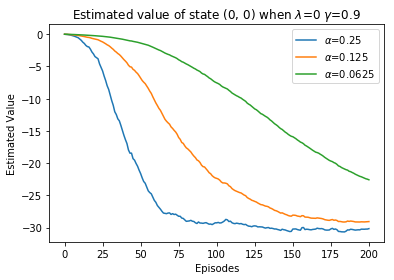

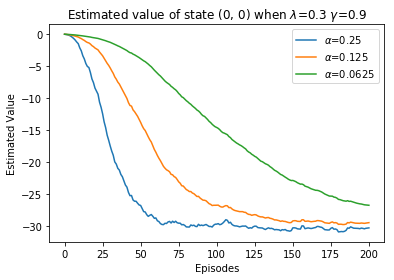

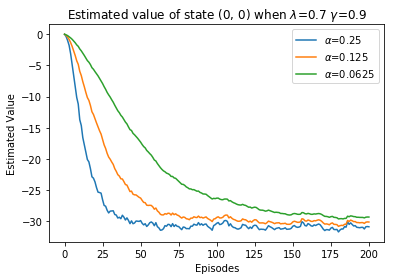

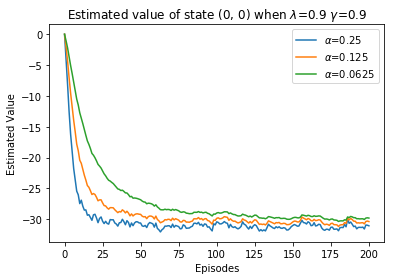

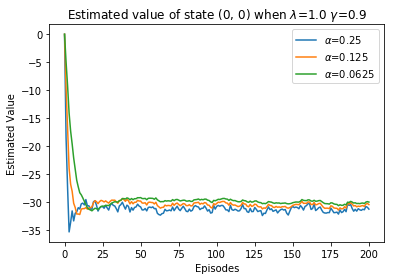

In [13]:
seed = 500
env = gym.make('Pendulum-v0').env
env.seed(seed)


observation = env.observation_space
low = np.array([-1*np.pi, -8])
high = np.array([1*np.pi,8])
action_low=env.action_space.low
action_high=env.action_space.high
n = 10
tiling_specs = [((n, n), (-0.1, +0.33)),
                ((n,n),(-0.05,+0.15)),
                ((n, n), (0.0, 0.0)),
                ((n, n), (0.05, -0.15)),
                ((n,n),(0.1, -0.33))]
tilings = Tilings(low, high, tiling_specs)



gamma =0.90

lamb_set = [0,0.3,0.7,0.9,1.0]
alpha_set = [1/20,1/40,1/80]

episode_n = 200
for lamb in lamb_set:
    result = np.zeros([len(alpha_set), episode_n+1])
    for idx,alpha in enumerate(alpha_set):
        Linear_Func = linear_function_approximator(tilings, -0.001,0.001,seed)
        Learning = Agent(env,lamb,
                 gamma, alpha, Linear_Func, episode_n
                 )
        result [idx] = Learning.Experiments(np.zeros(2))
        plt.plot(range(0,episode_n+1),result[idx],label=r"$\alpha$"+f"={5*alpha}")
        plt.legend()
        plt.xlabel("Episodes")
        plt.ylabel("Estimated Value")
        plt.title(f"Estimated value of state {(0,0)} when $\lambda$={lamb}"+" $\gamma$"+f"={gamma}")
    plt.show()

# Discussion

The TD($\lambda$) with eligibility trace has the following characteristics based on what we have observed on the graphs.<br>
1. There is a trend that a larger $\lambda$ leads to a faster convergence. See the $\lambda = 0.3$ case, it roughly converged from episode 75 when $\alpha=1/4$. On the contrary, the $\lambda=0.9$ case presents that the converge point is around episode 25, which is much earlier than the former one.
2. It could also be observed that learning rate also has a great impact on the performance of the algorithm. Apart from the last graph, in other four graphs, as the learning rate decreases, the algorithm converges at later episodes.
3. Beside convergence speed, learning rate also makes the final estimated value fall onto a larger number. For instance, $\lambda=0.9, \gamma =0.9$, the blue line converges to somewhere below -30, while the green line keeps above -30.
4. Also, a lower learning rate contributes to a lower divergence. Very apparently on the last graph, the blue line has more significant "ups and downs", however, the green curve looks more smoooth. Same thing also happens to the other cases.
5. The algorithm is a stable one because it eventually converges to almost the same value under each parametering setting. From the perspective of post-convergence, when the learning rate is larger, the algorithm is less stable in terms of oscillation.